## Mouse 🐁 : M044
Session: M044_2024_12_04_09_30


## 🧠 RNN training on single trial data and CURBD

In [3]:
# imports
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import mat73
from IPython.display import display, Markdown

import pyaldata as pyal
import pylab
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from tools.curbd import curbd
import pylab
import importlib

from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd.RNN_functions import *

np.random.seed(44)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [4]:
# data_dir = "/data/bnd-data/raw/M044/M044_2024_12_04_09_30"
# mat_file = "M044_2024_12_04_09_30_pyaldata.mat"

In [5]:
data_dir = "/Users/zosiasus/Documents/M044/"
mat_file = "M044_2024_12_04_09_30_pyaldata.mat"
fname = os.path.join(data_dir, mat_file)

df = pyal.mat2dataframe(fname, shift_idx_fields=True)
mouse = mat_file.split('_')[0]

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


### Preprocess

In [6]:
df_ = preprocess(df, only_trials=True)
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off
df_ = pyal.select_trials(df_, f"values_Sol_direction < 4") 

# Separate columns of 'all_spikes' to M1 and Dls (dorsolateral striatum)
brain_areas = ["Dls_rates", "M1_rates"]
df_["M1_rates"] = [df_["all_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_rates"][i][:,0:300] for i in range(len(df_))]

/Users/zosiasus/PyalData/pyaldata/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)


### Variables

In [7]:
# perturbation time
perturbation_time = df_.idx_sol_on[0]
perturbation_time_seconds = perturbation_time * df_.bin_size[0]

# solenoid angles
sol_angles: list = df_.values_Sol_direction.unique()
sol_angles.sort()

# number of trials
num_trials = len(df_)
print(f"Number of trials: {num_trials}")

Number of trials: 185


### Concatinate all trials in time

In [8]:
concat_trials = pyal.concat_trials(df_, signal = "all_rates")

#### Plot concatinted activity

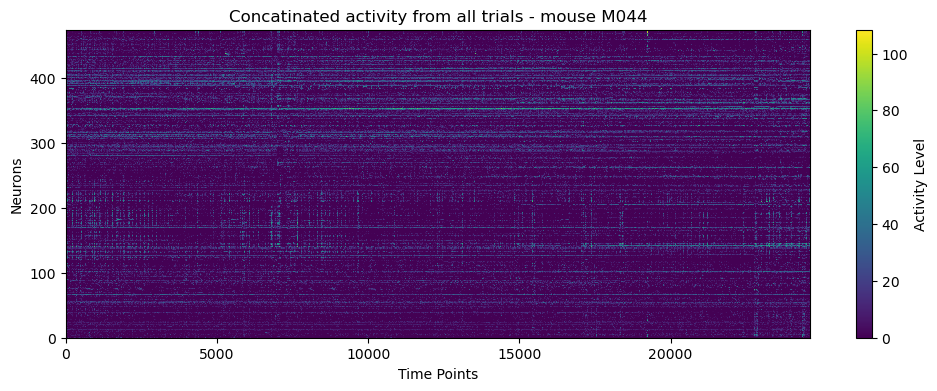

In [9]:
plot_neuron_activity(concat_trials, "Concatinated activity from all trials", mouse)

### Set up inputs for RNN training

In [10]:
dtFactor = 4
reset_points, trial_len = get_reset_points(df_, concat_trials, brain_areas, dtFactor)
activity = np.transpose(concat_trials)
regions = get_regions(df_, brain_areas)

print(f"Building {len(regions)} region RNN network")
print(f"Regions: {[region[0] for region in regions]}\n")

Building 2 region RNN network
Regions: ['Dls', 'M1']



### RNN training

In [11]:
# RNN TRAINING
rnn_model, rnn_accurancy_figure = RNN(activity, reset_points, regions, df_, mouse, 
                                                        dtFactor = dtFactor, ampInWN= 0.001, tauRNN = 0.2, nRunTrain=200)

KeyboardInterrupt: 

#### Transform RNN output - combine time bins

In [ ]:
rnn_model_ = rnn_model.copy()
rnn_model_['RNN'] = combine_rnn_time_bins(rnn_model)

#### Plot activity generated by RNN

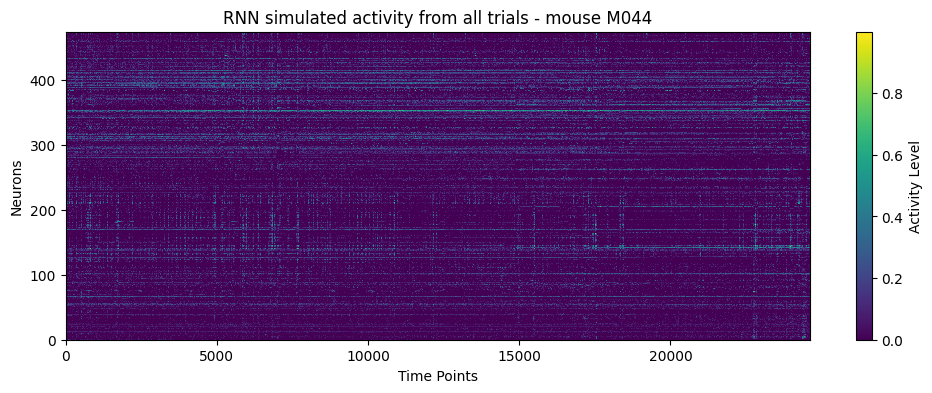

In [115]:
plot_neuron_activity(rnn_model['Adata'].T, "RNN simulated activity from all trials", mouse)

### RNN assesment with PCA and CCA

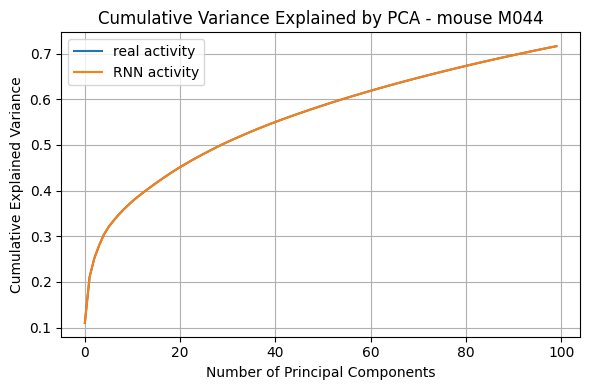

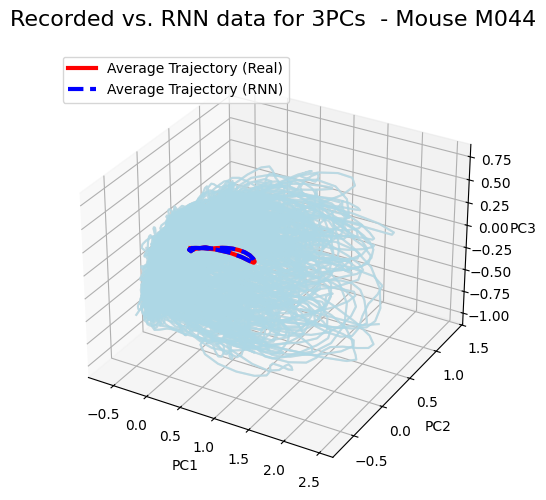

CCA score of real data and RNN data aligment: 0.9999990043689118
CCA score for control on real data: 0.9999999999999994
CCA score for control on rnn data: 0.9999999999999994


In [137]:
scores, variance_figure, PCA_figure = PCA_and_CCA(concat_trials, rnn_model_, 
                                                                  num_components = concat_trials.shape[1]-1, trial_num = num_trials, mouse_num = mouse, 
                                                                  printing=True)

## PCA by region

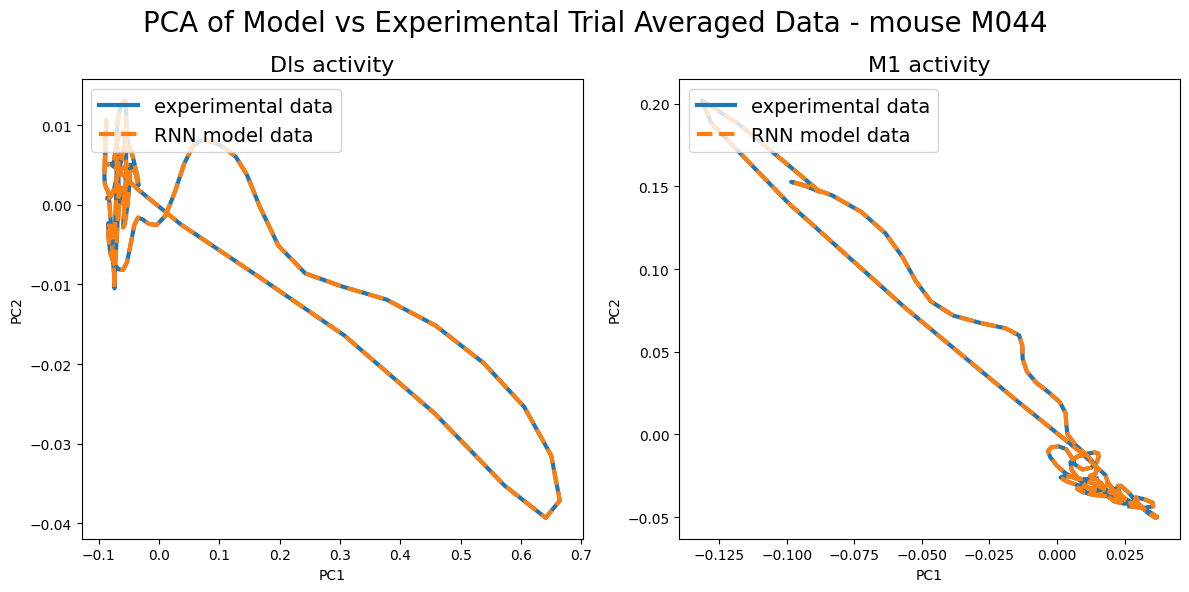

In [141]:
fig1 = PCA_by_region(concat_trials, rnn_model_, regions, num_trials, mouse)

In [142]:
matrix = rnn_model['J']

neuron_num = rnn_model['Adata'].shape[0]
m1_end = regions[0][1][-1]
dls_start = regions[1][1][-1]

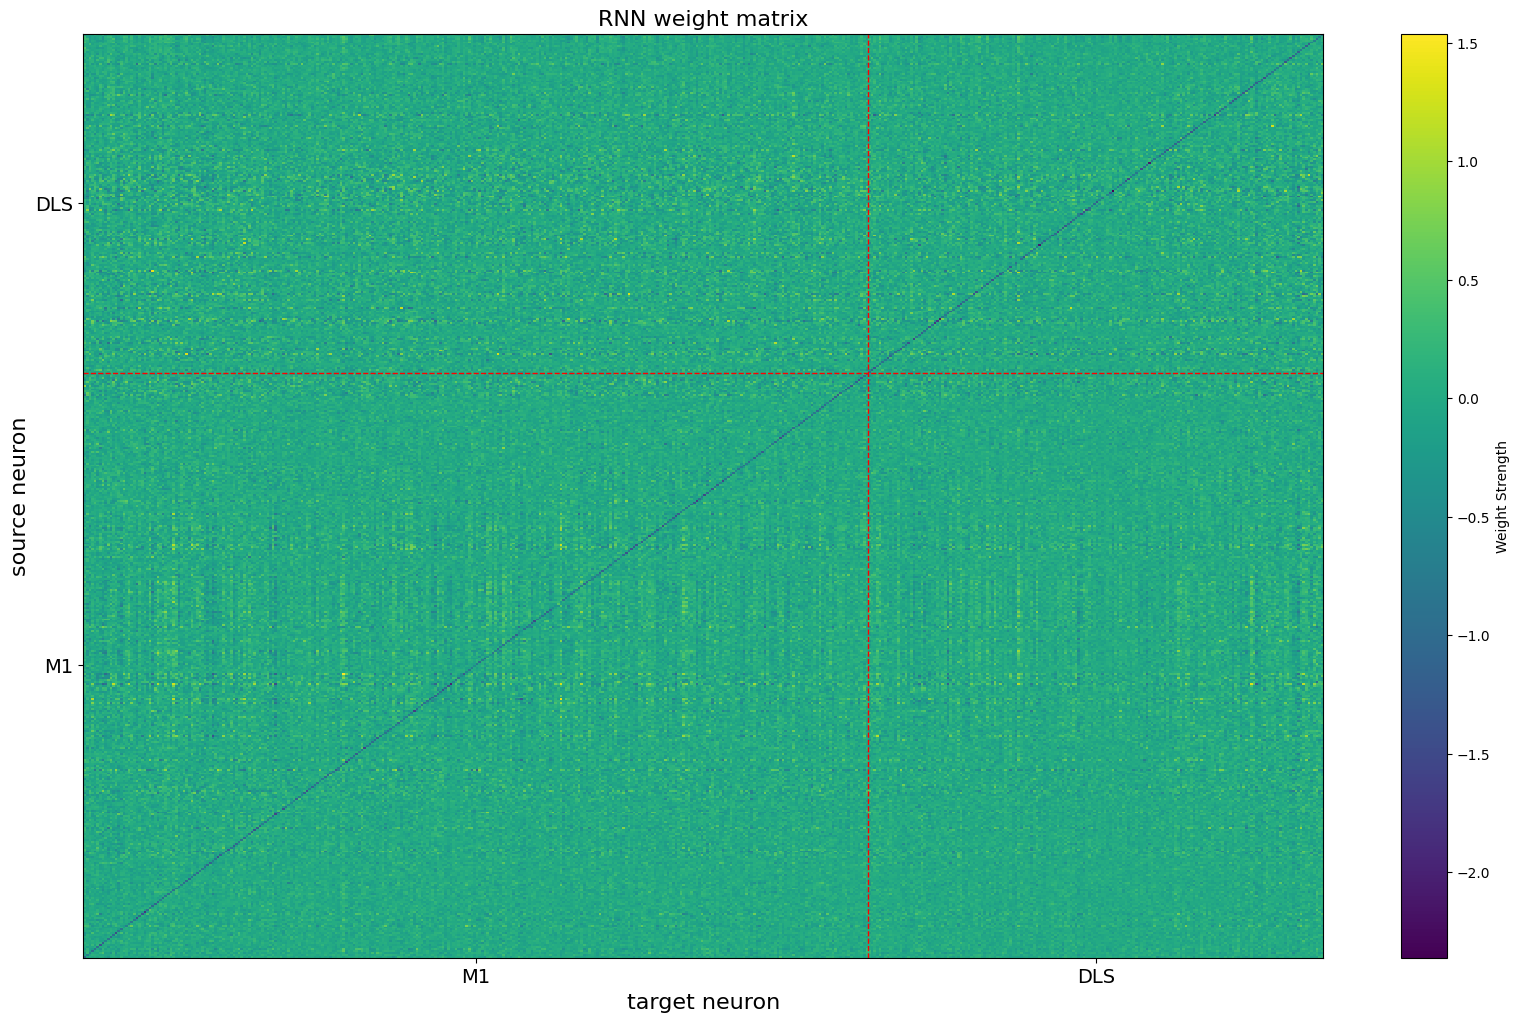

In [ ]:
fig = plt.figure(figsize=[20, 12])

plt.pcolormesh(range(neuron_num), range(neuron_num), matrix, cmap="viridis")

plt.colorbar(label="Weight Strength")

plt.axvline(x=m1_end + 0.5, color='red', linestyle='--', linewidth=1, label="M1-DLS Boundary")
plt.axhline(y=m1_end + 0.5, color='red', linestyle='--', linewidth=1)

plt.xticks([m1_end / 2, (neuron_num - (neuron_num - m1_end)/2) ], ["M1", "DLS"], fontsize=14)
plt.yticks([m1_end / 2, (neuron_num - (neuron_num - m1_end)/2)], ["M1", "DLS"], fontsize=14)

plt.title('RNN weight matrix', fontsize=16)
plt.xlabel('target neuron', fontsize=16)
plt.ylabel('source neuron', fontsize=16)
plt.show()

### CURBD

In [122]:
curbd_arr, curbd_labels = curbd.computeCURBD(rnn_model)
n_regions = curbd_arr.shape[0]

### Plotting currents

In [123]:
all_currents, all_currents_labels = format_for_plotting(curbd_arr, curbd_labels, n_regions, reset_points)

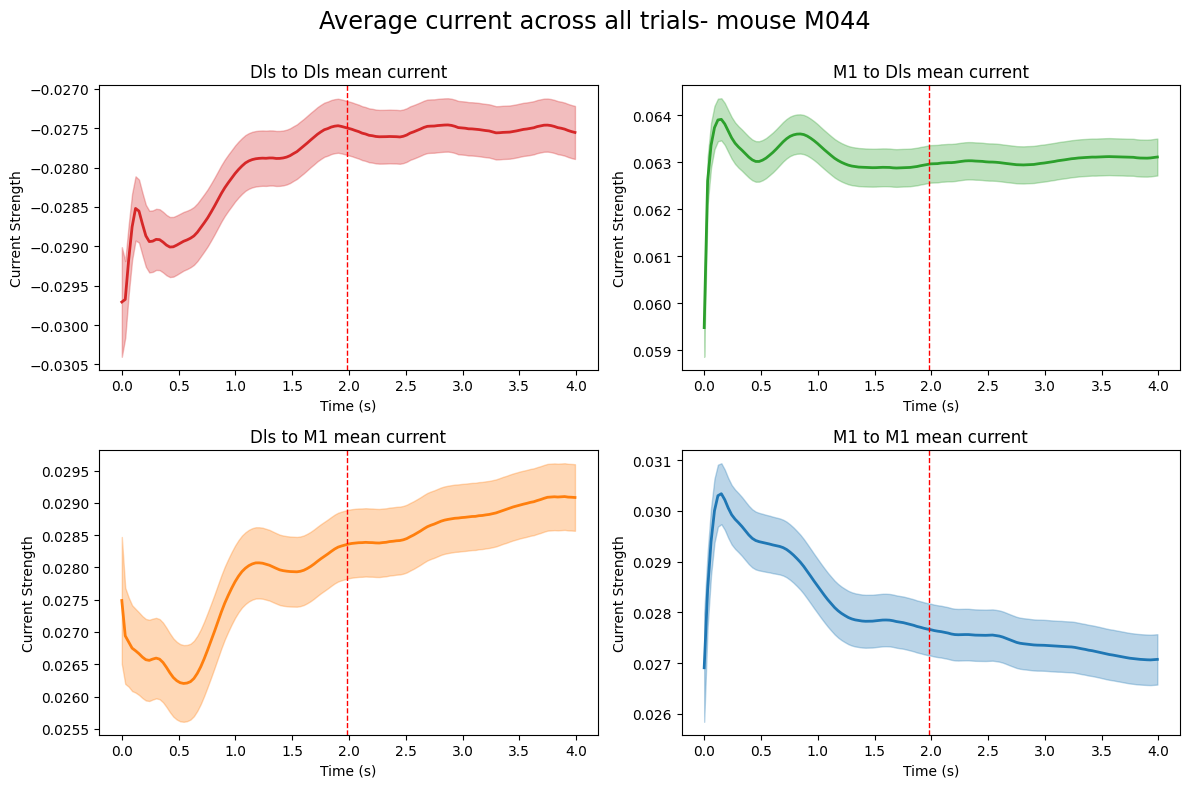

In [133]:
avg_currents_fig = plot_all_currents_seperate(all_currents, all_currents_labels, perturbation_time_seconds, df_.bin_size[0], dtFactor, mouse, plot_single = False)

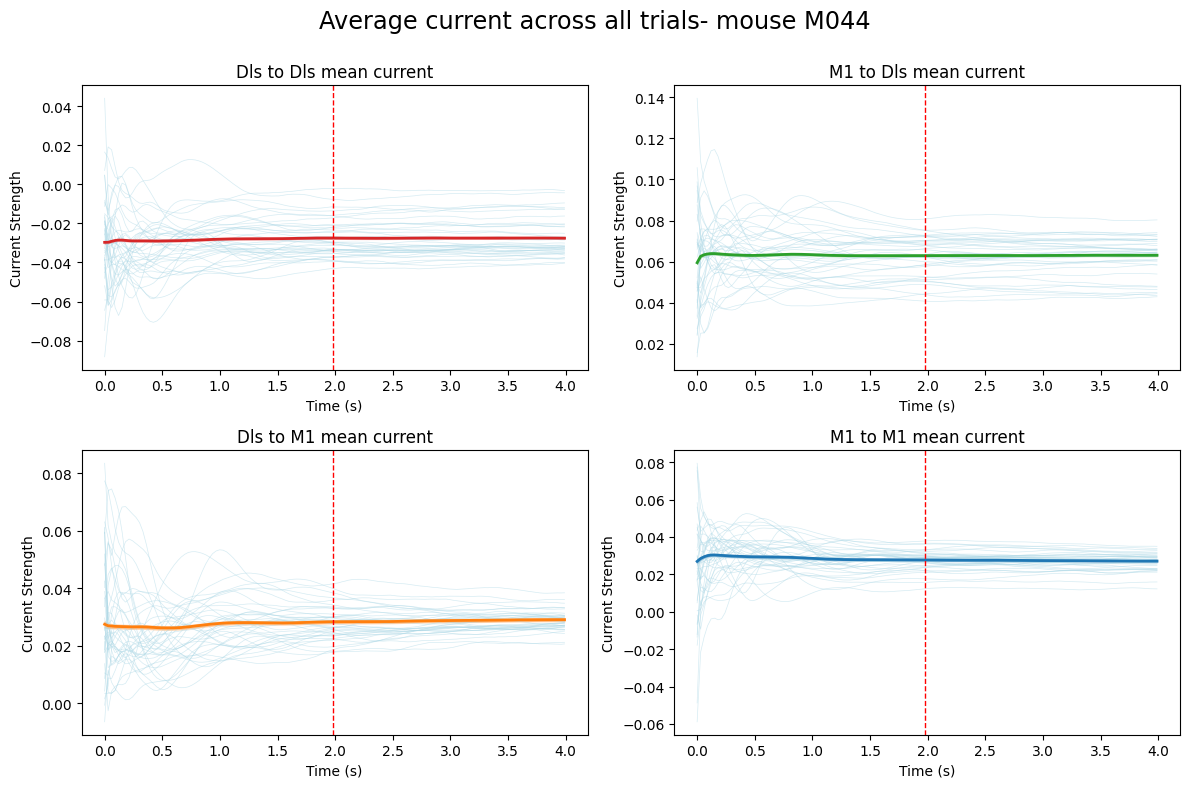

In [134]:
avg_currents_fig = plot_all_currents_seperate(all_currents, all_currents_labels, perturbation_time_seconds, df_.bin_size[0], dtFactor, mouse, plot_single = True)